# Normalizing flows tutorial - Papercup
Copyright 2020-present, Papercup Technologies Limited  
All rights reserved

Author: Raphael Lenain

__This tutorial is "translated" from the Jax tutorial at ICML 2019, run by Eric Jang at Google.__

## Necessary imports
Please remember to activate using GPU on Colab. See this guide for help: https://jovianlin.io/pytorch-with-gpu-in-google-colab/

In [ ]:
from torch import distributions
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# Use GPU on Colab.
torch.cuda.set_device(0)

### We use the noisy moons dataset from sklearn.datasets

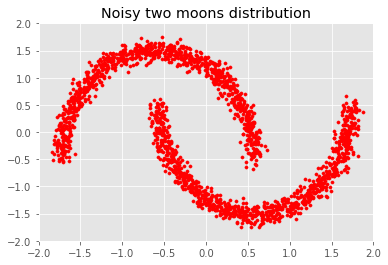

In [ ]:
n_samples = 2000

# Define distribution. 
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)

# Plot.
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.title('Noisy two moons distribution')
plt.ylim(ylim);

Let's explore what sampling from $N(0, I)$ looks like and overlay it with the noisy two moons.  
As you can see very well below, $N(0, I)$ and the noisy moons distributions are very different.

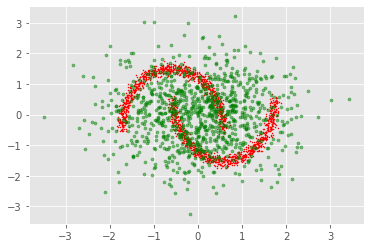

In [ ]:
# Define a function which samples from N(0, I)
def sample_n01(N):
    # Sample from a normal(0, 1) distribution.
    D = 2
    return np.random.normal(size = (N, D))

# N(0, I)
X_normal = sample_n01(1000)

# Plot
plt.scatter(X[:, 0], X[:, 1], s=1, color='red', alpha=1)
plt.scatter(X_normal[:, 0], X_normal[:, 1], s=10, color='green', alpha=0.5)
plt.show()

### Loglikelihood of the two moons data under the normal distribution.
Under the two moons data, this data is clearly bimodal. This makes sense as there are two moons, right?  
In particular, you can tell that modeling the noisy moons distribution with $N(0, I)$ is quite a poor choice.

In [ ]:
def normal_prob(x):
  return np.sum(np.exp(-(x**2)/2)/np.sqrt(2 * np.pi),axis=1)

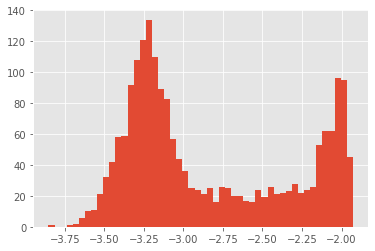

In [ ]:
# In the case of this tutorial, this function takes as input a list of 2 dimensional points, 
# and returns the list of the loglikelihoods of these points under the N(0, I) distribution.
def log_prob_n01(x):
    # Evaluate log likelihood under the normal distribution.
    return np.sum(- np.square(x) / 2 - np.log(np.sqrt(2 * np.pi)), axis=-1)

# Plot
plt.hist(log_prob_n01(X), bins=50)
plt.show()

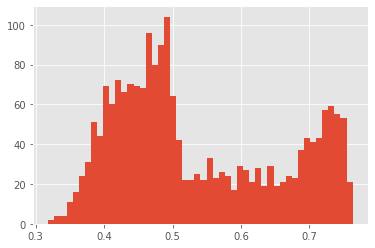

In [ ]:
plt.hist(normal_prob(X), bins=50)
plt.show()

### For comparison, loglikelihood of the normal(0, I_2) distributed data
You can see here what evaluating the loglikelihood of a dataset under its correct distribution should look like.  

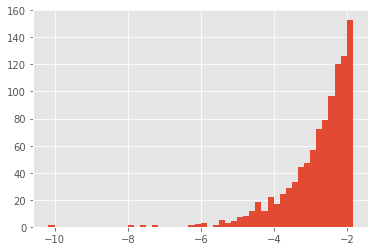

In [ ]:
# Plot the loglikelihood of the N(0, I) data under the N(0, I) distribution ("correct" model).
plt.hist(log_prob_n01(X_normal), bins=50)
plt.show()

## Define the model
The math here does not matter too much. If you are interested in the math of this, I can refer you to [the original paper](https://arxiv.org/abs/1605.08803), RealNVP.  

This is the blog post by the original editor of the tutorial in Jax from which I wrote this tutorial: https://blog.evjang.com/2018/01/nf2.html. It also explains the math of the `NVP` class below quite well. 

Because of this I will not describe the math extensively here. 

__Note that NVP stands for "Non volume preserving".__

In [ ]:
class NVP(nn.Module):
    def __init__(self, flips, D=2, out=4):
        super().__init__()
        self.D = D
        self.flips = flips
        self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
        self.shift_log_scale_fns = nn.ModuleList()
        for _ in flips:
            shift_log_scale_fn = nn.Sequential(
              nn.Linear(2, 16),
                nn.Tanh(),
                nn.Linear(16, out)
                )
            self.shift_log_scale_fns.append(shift_log_scale_fn)
    
    def forward(self, z, flip_idx):
      
        # net_out = self.shift_log_scale_fns[flip_idx](z)
        # shift, log_scale = net_out.split(self.D, dim=1)
        # X = z * torch.exp(log_scale) + shift
        
        X = torch.zeros_like(z)
        for i in range(z.shape[1]):
            net_out = self.shift_log_scale_fns[flip_idx](X.clone()) # clone to avoid in-place op errors if using IAF
            shift, log_scale  =  net_out.split(self.D, dim=1)
            X[:, i] = z[:,i] * torch.exp(log_scale[:,i]) + shift[:,i]
            
            
        # flip = self.flips[flip_idx]
        # i = int(flip)
        # X = torch.ones_like(z)
        # X[:,i] = z[:,i]
        # net_out = self.shift_log_scale_fns[flip_idx](z[:,i].unsqueeze_(1))
        # shift, log_scale = net_out[:,0], net_out[:,1]    #.split(self.D, dim=1)
        # X[:,1-i] = z[:,i] * torch.exp(log_scale) + shift

        return X
    
    def inverse_forward(self, z, flip_idx):

        flip = self.flips[flip_idx]
        Y = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0)).cuda()

        
        for i in range(z.shape[1]):
            net_out = self.shift_log_scale_fns[flip_idx](Y.clone()) # clone to avoid in-place op errors if using IAF
            shift, log_scale  =  net_out.split(self.D, dim=1)
            Y[:, i] = (z[:, i] - shift[:, i]) * torch.exp(-log_scale[:, i])
            log_det += log_scale[:,i]


        
        # for i in range(z.shape[1]):
        #     net_out = self.shift_log_scale_fns[flip_idx](Y.clone()) # clone to avoid in-place op errors if using IAF
        #     shift, log_scale  =  net_out.split(self.D, dim=1)
        #     Y[:, i] = (z[:, i] - shift[:, i]) * torch.exp(-log_scale[:, i])
        #     log_det += log_scale[:,i]


        # i = int(flip)
        # Y[:,i] = z[:,i]
        # net_out = self.shift_log_scale_fns[flip_idx](z[:,i].unsqueeze_(1).clone()) # clone to avoid in-place op errors if using IAF
        # shift, log_scale  =  net_out[:,i], net_out[:,1]  #net_out.split(self.D, dim=1)
        # Y[:, 1-i] = (z[:, i] - shift) * torch.exp(-log_scale)
        # log_det = torch.abs(log_scale) + 1e-6 
        
        return Y, log_det
    
    @staticmethod
    def base_log_prob_fn(x):
        return torch.sum(- (x ** 2) / 2 - np.log(np.sqrt(2 * np.pi)), -1)
    
    def base_sample_fn(self, N):
        # sampler random normal(0, I)
        x = self.prior.sample((N, 1)).cuda().squeeze(1)
        return x

    # WHY DO WE NEED THIS FUNTION ? 
    def log_prob(self, y, flip_idx):
        x, log_scale = self.inverse_forward(y, flip_idx)
        # This comes from the jacobian. In this case the jacobian is simply the product of the scales,
        # which becomes the sum of log scales in the loglikelihood.
        ildj = - torch.sum(log_scale, -1)
        return self.base_log_prob_fn(x) + ildj
    
    # USE xs TO SAMPLE BY LAYER FOR EDA PUROPOUSE ONLY
    # FOR MAPPING CAN USE LAST OUTPUT
    def sample_nvp_chain(self, N):
        xs = []
        x = self.base_sample_fn(N)
        xs.append(x)
        print('ok')
        for i, _ in enumerate(self.flips):
            x = self.forward(x, flip_idx=i)
            xs.append(x)
        return x, xs
    
    # NOISY MOONS as Y
    def iter_flips_inverse_chained(self, y):
        # Run y through all the necessary inverses, keeping track
        # of the logscale along the way, allowing us to compute the loss.
        temp = y
        logscales = y.data.new(y.shape[0]).zero_()
        for i, _ in enumerate(self.flips):
            temp, logscale = self.inverse_forward(
                                              temp, 
                                              flip_idx=len(self.flips) - 1 - i)
            
            # One logscale per element in a batch per layer of flow.
            logscales += logscale.squeeze(-1)
        #print('Mean of log scales: ', torch.mean(logscales))
        return self.base_log_prob_fn(temp) - logscales  # SUMM OF SCALES AS OUR DERTERMINANT and final model output


flips = [False, True, False, True, False, True,False, True]
model = NVP(flips).cuda()

### Define your NVP object. 
We define our model. In order to define our model, we need to give it a hyperparameter: the number of layers.  
The number of layers is the length of flips. For reasons explained well in the blog post by Eric Jang, they have to alternate a function, which is why there is this __False/True/...__ structure.

### Loglikelihood of the two moons data under this new distribution.
We have a new distribution which is computed using the $N(0, I)$ distribution and the model which we have just defined.
These are still quite low and does not have the same structure as what we saw when we evaluated the $N(0, I)$ data under the $N(0, I)$ distribution.  

__This makes sense, the model hasnt been trained yet.__

## Training!

In [ ]:
# Training hyperparameters.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Increase or decrease this if you wish.
iters = 5000

train_enum = range(iters - 1)

# Initialise the minimum loss at infinity.
min_loss = float('inf')

# Iterate over the number of iterations.
for i in train_enum:
    # Sample from our "dataset". We artificially have infinitely many data points here.
    noisy_moons = datasets.make_moons(n_samples=128, noise=.05)[0].astype(np.float32)
    #noisy_moons = StandardScaler().fit_transform(noisy_moons)

    optimizer.zero_grad()
    
    batch = torch.FloatTensor(noisy_moons).cuda()   # log (p(f)) + log(scale_1*scale_2* ... *scale_k)  p is normal distribution 
    out_forwardpass = model.iter_flips_inverse_chained(batch)
    loss = - torch.mean(out_forwardpass)
    # If the loss is lower than anything already encountered, consider that the "best model".
    if loss.item() < min_loss:
        bestmodel = model
    
    # Backpropagation.
    loss.backward()
    optimizer.step()
    if i % 500 == 0:
        print('Iter {}, loss is {:.3f}'.format(i, loss.item()))

Iter 0, loss is 6.490
Iter 500, loss is 1.541
Iter 1000, loss is 1.415
Iter 1500, loss is 1.299
Iter 2000, loss is 1.295
Iter 2500, loss is 1.386
Iter 3000, loss is 1.321
Iter 3500, loss is 1.292
Iter 4000, loss is 1.280
Iter 4500, loss is 1.283


### We have trained our model. Now we "sample the NVP chain".
What does sampling the NVP chain mean? Well, we sample from $N(0, I)$, and apply the sequence of learned transformations.

ok


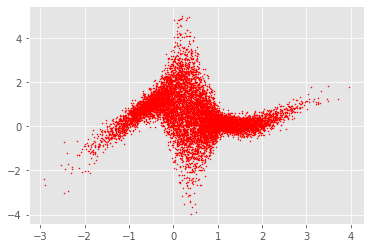

In [ ]:
new_Xs, _ = model.sample_nvp_chain(10000)
new_Xs = new_Xs.data.cpu().numpy()

# Plot.
plt.scatter(new_Xs[:, 0], new_Xs[:, 1], c='r', s=1)
plt.show()

### Make that GIF now
Now we will make a pretty visualisation.

In [ ]:
# Necessary imports for this part.

from matplotlib import animation, rc
from IPython.display import HTML, Image

def animate(i):
    l = i//48
    t = (float(i%48))/48
    y = (1-t)*xs_list[l] + t*xs_list[l+1]
    paths.set_offsets(y)
    return (paths,)

Run the cell below to plot images of the intermediary outputs.  


ok


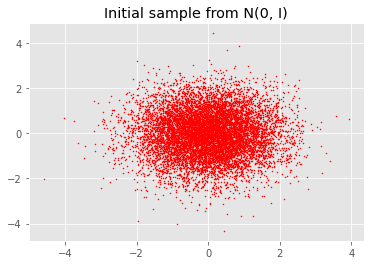

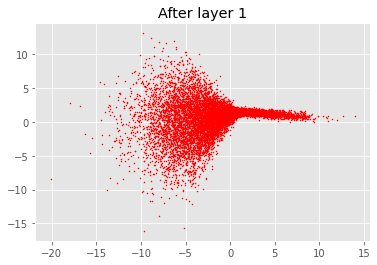

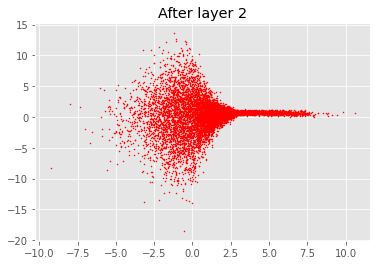

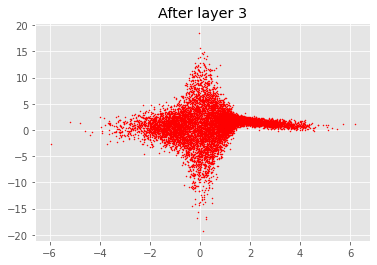

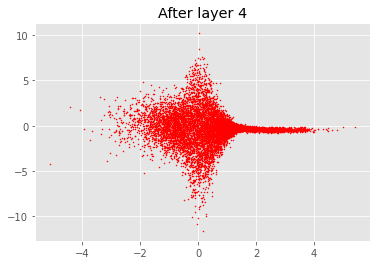

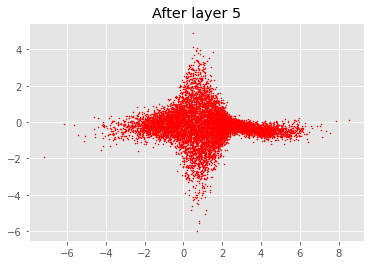

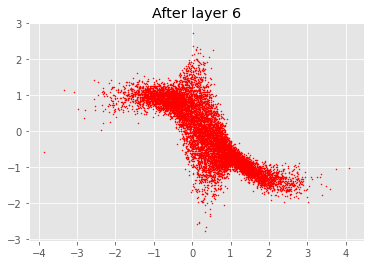

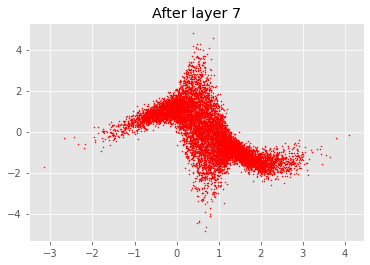

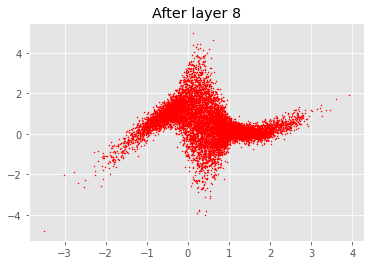

In [ ]:
# Sample the NVP chain, and keep track of the intermediary outputs between each layer in the sequence.
new_Xs, xs_list = model.sample_nvp_chain(10000)
new_Xs = new_Xs.data.cpu().numpy()
xs_list = [x.data.cpu().numpy() for x in xs_list]

# Plot initial sample from N(0, I)
plt.scatter(xs_list[0][:, 0], xs_list[0][:, 1], c='r', s=1)
plt.title('Initial sample from N(0, I)')
plt.show()

# Plot intermediary outputs.
for i, x in enumerate(xs_list[1:]):
    plt.scatter(x[:, 0], x[:, 1], c='r', s=1)
    plt.title('After layer {}'.format(i + 1))
    plt.show()

This cell also generates a GIF at `MyFunGif.gif` which you can download from the tab on the left in "Files" and look at.  
__The cell below might take a while!!__

In [ ]:
# # Make the cool GIF image.
# fig, ax = plt.subplots()
# ax.set_xlim(-3, 3)
# ax.set_ylim(-3, 3)
# paths = ax.scatter(xs_list[0][:, 0], xs_list[0][:, 1], s=1, color='red')

# anim = animation.FuncAnimation(fig, animate, frames=48*len(flips), interval=1, blit=False)
# anim.save('MyFunGif.gif', writer='imagemagick', fps=60)